# Heart failure outcome classifier
In this notebook we will take a dive into a [this](https://www.kaggle.com/datasets/asgharalikhan/mortality-rate-heart-patient-pakistan-hospital) dataset of heart failures in Pakistan.  
While I am **not** a medical professional and know only slightly more about heart failures than an average person, I will try to create a model, that will predict the mortality of a heart failure in the Pakistani settings. This model might not work to predict the mortality in other countries, which are more or less medically advanced. 

> **Disclaimer!** This is not a medical study nor recommendation!

## How will it work?
With hypothesis testing, I will determine, which of the features of the patients attribute to the heart failure the most to mortality. Having the best features selected, I will create a model, that will predict the mortality for the given sample of patients. Once the model is created with best possible scores, I will check and determine, which of the features impact mortality the most. 

## How is this model useful?
Knowing the most crucial features that might contribute to fatal heart failure, users of this model might check if in their current health, would they survive a heart failure in Pakistan. In another setting, if the model predicts fatality, whils the user is alive, it might be a suggestion to consult with their doctor the state of their health, to avoid heart failure in the future - this aspect might be useful in any different settings.

## Good to know
Data analized in this study does not touch on the accessability to the hospital or a doctor, time of diagnosis, CPR occurrecne and duration, threatment, how long did it take for the patient to receive firts aid, how far were they from the nearest hospital, chronic diseases, etc. While the dataset gives a good insight on the patients parameters, many life-saving aspects are not included, therefore any conclusions, especially resulting in death on a user of this model should not be taken too seriously. These might however suggest to schedule a check-up with the users doctor.

# Exploratory data analysis

In [1]:
# setting the environment
import re
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

import optuna
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix)
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from xgboost import XGBClassifier


# there are many columns, I want to see them all
pd.set_option('display.max_columns', 500)

In [2]:
df = pd.read_csv('data/heart_failure_dataset.csv')

# column names are strangely formated, let's fix them quick
replace_dict = {}

for c in df.columns:
    if c not in replace_dict.keys():
        replace_dict[c] = c.replace(' ', '').replace('.', '')     
                                    
df = df.rename(columns=replace_dict)
df.head(5)

,Age,AgeGroup,Gender,Locality,Maritalstatus,LifeStyle,Sleep,Category,Depression,Hyperlipi,Smoking,FamilyHistory,FHistory,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,Others,CO,Diagnosis,Hypersensitivity,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,SKReact,Reaction,Mortality,FollowUp
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,1,NO,NO,100.6,0,84,28.0,0.9,138,3.3,107,130,30,11,9900,4.26,11.6,0.34,79.7,27.2,0.34,265000,0.70,0.25,0.03,2,no,"Chest pain,",EXT. ACUTE WALL M.I,NO,4,132,341,1,2,136,1,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,0,NO,NO,90.6,0,135,17.0,0.7,144,4.7,104,163,30,27,15800,5.74,14.5,0.44,78.0,25.0,0.32,287000,0.73,0.20,0.04,3,no,"Central Chest pain,",A/W M.I,NO,4,130,305,0,0,142,1,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,100.7,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,LV dysfunction,"Chest pain,SOB, Cold sweating",AC I/W M.I (RV) RE. M.I,NO,4,180,327,0,1,117,1,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,160.1,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,HTN,"CENTRAL Chest pain,",I/W M.I,NO,4,128,205,0,1,130,1,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,NO,NO,0,1,YES,NO,90.6,0,85,78.0,1.2,139,4.5,112,75,18,13,6900,4.41,12.3,0.36,82.0,27.0,0.33,211000,0.71,0.25,0.02,2,no,"Chest pain,",A/W M.I,NO,4,200,288,1,2,133,1,4.0,3,2,7,3,1,NO,0,0,34


In [3]:
df.shape

(368, 60)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368 entries, 0 to 367
Data columns (total 60 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Age               368 non-null    int64  
 1   AgeGroup          368 non-null    object 
 2   Gender            368 non-null    object 
 3   Locality          368 non-null    object 
 4   Maritalstatus     368 non-null    object 
 5   LifeStyle         368 non-null    object 
 6   Sleep             368 non-null    object 
 7   Category          368 non-null    object 
 8   Depression        368 non-null    object 
 9   Hyperlipi         368 non-null    object 
 10  Smoking           368 non-null    object 
 11  FamilyHistory     368 non-null    object 
 12  FHistory          368 non-null    int64  
 13  Diabetes          368 non-null    int64  
 14  HTN               368 non-null    object 
 15  Allergies         368 non-null    object 
 16  BP                368 non-null    float64
 1

In [5]:
df.isna().sum().sum() # there are no NaN values in the dataset

0

In [6]:
# FamilyHistory is the same as FHistory, just not encoded, let's drop it
df = df.drop('FamilyHistory', axis=1)

In [7]:
df.duplicated().sum() # seems there is a lot of duplicates

214

In [8]:
mortality_percentage = df['Mortality'].value_counts(normalize=True) * 100
mortality_percentage

0    78.26087
1    21.73913
Name: Mortality, dtype: float64

Upon further inspection of the dataset, majority of rows are duplicated, which is unfortunate, as this dataset it pretty small.

The differences between the statistics of the dataset with and without the duplicates are similar, and with the duplicates the percentage of patients, who survided the heart failure is larger - this makes the data less unbalanced. 

For the modeling, we will use the dataset with the duplicates, since most of the data is distibuted the same, however for hypothesis testing we will only compare the dataset without the duplicates, so that these will not affect the differences.

In [9]:
# let's create a copy - a clear dataset
df_c = df.copy()
df_c = df_c.drop_duplicates()

In [10]:
# let's check the mortality rate in clean dataset
mortality_percentage_c = df_c['Mortality'].value_counts(normalize=True) * 100
mortality_percentage_c

0    82.467532
1    17.532468
Name: Mortality, dtype: float64

In [11]:
df_c.describe() # now that duplicates are gone, let's see how our data looks

,Age,FHistory,Diabetes,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,Reaction,Mortality,FollowUp
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,55.772727,0.194805,0.409091,118.165779,0.051948,227.948052,47.135714,1.490000,137.987013,4.194805,103.461039,637.694805,69.396104,25.720779,11171.363636,5.115325,13.840260,0.417208,81.033766,27.059740,0.326753,245792.207792,2.294286,0.249026,0.033117,2.214286,3.590909,133.396104,249.448052,0.149351,1.162338,139.993506,0.551948,1.531169,1.818182,1.051948,5.896104,2.032468,0.974026,0.759740,0.175325,28.902597
std,9.036978,0.397343,0.493270,23.459274,0.222646,141.137804,54.496293,3.079576,3.993437,0.369559,4.628885,1085.768192,100.175233,28.377358,3360.261441,0.775705,2.162319,0.065744,7.304875,3.330735,0.027839,78208.509251,11.413506,0.117366,0.015946,0.877938,0.844928,18.592788,49.913133,0.357597,0.980001,22.523915,0.498917,1.300403,0.565391,1.027671,1.715629,1.012464,0.159577,0.428635,0.381485,16.567457
min,24.000000,0.000000,0.000000,80.500000,0.000000,60.000000,2.300000,0.600000,129.000000,3.300000,90.000000,52.000000,14.000000,5.000000,5800.000000,3.460000,9.100000,0.290000,60.000000,18.000000,0.220000,20000.000000,0.360000,0.050000,0.010000,1.000000,1.000000,100.000000,131.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,52.000000,0.000000,0.000000,100.625000,0.000000,127.000000,28.000000,0.800000,135.000000,3.900000,100.000000,131.250000,22.000000,11.000000,7900.000000,4.410000,12.300000,0.360000,78.000000,25.000000,0.320000,187000.000000,0.600000,0.170000,0.020000,2.000000,4.000000,120.000000,213.000000,0.000000,0.000000,125.000000,0.000000,0.225000,1.000000,0.000000,3.750000,1.000000,1.000000,1.000000,0.000000,15.000000
50%,57.000000,0.000000,0.000000,120.700000,0.000000,165.000000,35.500000,0.900000,138.000000,4.200000,104.000000,192.000000,39.000000,16.000000,10400.000000,5.230000,14.100000,0.420000,82.100000,27.800000,0.330000,237000.000000,0.720000,0.210000,0.030000,2.000000,4.000000,130.000000,248.500000,0.000000,2.000000,142.000000,1.000000,1.400000,2.000000,1.000000,7.000000,2.000000,1.000000,1.000000,0.000000,32.000000
75%,61.000000,0.000000,1.000000,130.800000,0.000000,320.000000,42.000000,1.080000,140.750000,4.400000,106.000000,446.000000,52.000000,27.000000,13800.000000,5.650000,15.500000,0.460000,86.000000,29.000000,0.340000,284000.000000,0.797500,0.320000,0.040000,3.000000,4.000000,143.500000,283.000000,0.000000,2.000000,156.750000,1.000000,2.475000,2.000000,2.000000,7.000000,3.000000,1.000000,1.000000,0.000000,36.000000
max,77.000000,1.000000,1.000000,190.110000,1.000000,563.000000,394.000000,22.900000,146.000000,5.300000,112.000000,4289.000000,505.000000,154.000000,19590.000000,6.980000,18.000000,0.540000,96.000000,33.000000,0.390000,459000.000000,83.000000,0.540000,0.080000,5.000000,4.000000,200.000000,409.000000,1.000000,2.000000,195.000000,1.000000,6.200000,3.000000,3.000000,7.000000,4.000000,1.000000,1.000000,1.000000,60.000000


In [12]:
def outliers(dataframe, column):
    outliers = []
    q1 = np.percentile(sorted(dataframe[column]), 25)
    q3 = np.percentile(sorted(dataframe[column]), 75)
    IQR = q3 - q1
    lwr_bound = q1 - (1.5 * IQR)
    upr_bound = q3 + (1.5 * IQR)
    for i in sorted(dataframe[column]): 
        if (i < lwr_bound or i > upr_bound):
            outliers.append(i)
    return outliers, lwr_bound, upr_bound

In [13]:
# let's see how do the outliers look
numeric_columns = df_c.select_dtypes(include=['int64', 'float64']).columns
outlier_dict = {}

for c in numeric_columns:
    empty = []
    outlier = outliers(df_c, c)[0]
    if outlier != empty:
        outlier_dict[c] = outliers(df, c), len(outliers(df, c)[0])
        
print(outlier_dict.keys())

dict_keys(['Age', 'FHistory', 'BP', 'Thrombolysis', 'BUrea', 'SCr', 'SPotassium', 'SChloride', 'CPK', 'CKMB', 'ESR', 'MCV', 'MCH', 'MCHC', 'PLATELET_COUNT', 'NEUTROPHIL', 'MONOCYTE', 'EOSINO', 'cp', 'trestbps', 'chol', 'fbs', 'thalach', 'oldpeak', 'SK', 'Reaction', 'Mortality'])


It seems there is a bit of outliers, but this should be examined by a medical professional.
In my unprofessional opinion with help from google, all of those should slide, since these are possible to be observed. Some of these, especially really high or really low values might be correlated with the mortality of the heart failure.

In [102]:
# CO is VERY messy, firstly let's change is all to lower case to avoid trouble
df['CO'] = df['CO'].str.lower().str.replace(r'\d', '', regex=True)

# let's remove the numbers, time and prepositions... and chest pain, all have chest pain
df['CO'] = df['CO'].str.lower().str.replace('central', '')
df['CO'] = df['CO'].str.replace('chest pain,', '')
df['CO'] = df['CO'].str.replace('day', '')
df['CO'] = df['CO'].str.replace('to', '')
df['CO'] = df['CO'].str.replace('hr', '')
df['CO'] = df['CO'].str.replace('for', '')
df['CO'] = df['CO'].str.replace('from', '')
df['CO'] = df['CO'].str.replace('chest pain', '')
df['CO'] = df['CO'].str.strip()
df['CO'] = df['CO'].replace('', 'none')


# we will do it similarely as previously
#df['CO'] = df['CO'].apply(lambda x: 0 if x == '' else x.count(',') + 1)

df.head()

,Age,AgeGroup,Gender,Locality,Maritalstatus,LifeStyle,Sleep,Category,Depression,Hyperlipi,Smoking,FamilyHistory,FHistory,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,Others,CO,Diagnosis,Hypersensitivity,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,SKReact,Reaction,Mortality,FollowUp
0,45,41-50,Female,RURAL,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,1,NO,NO,100.6,0,84,28.0,0.9,138,3.3,107,130,30,11,9900,4.26,11.6,0.34,79.7,27.2,0.34,265000,0.70,0.25,0.03,2,no,none,EXT. ACUTE WALL M.I,NO,4,132,341,1,2,136,1,3.0,2,0,7,2,1,NO,0,0,60
1,51,51-60,Female,URBAN,MARRIED,NO,NO,FREE,YES,YES,NO,NO,0,0,NO,NO,90.6,0,135,17.0,0.7,144,4.7,104,163,30,27,15800,5.74,14.5,0.44,78.0,25.0,0.32,287000,0.73,0.20,0.04,3,no,none,A/W M.I,NO,4,130,305,0,0,142,1,1.2,2,0,7,2,1,NO,0,0,15
2,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,100.7,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,LV dysfunction,"sob, cold sweating",AC I/W M.I (RV) RE. M.I,NO,4,180,327,0,1,117,1,3.4,2,0,3,2,1,NO,0,0,6
3,55,51-60,Female,RURAL,MARRIED,YES,YES,FREE,YES,YES,NO,NO,0,1,YES,NO,160.1,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,HTN,none,I/W M.I,NO,4,128,205,0,1,130,1,2.0,2,1,7,3,1,NO,0,0,52
4,56,51-60,Female,RURAL,MARRIED,YES,NO,FREE,YES,YES,NO,NO,0,1,YES,NO,90.6,0,85,78.0,1.2,139,4.5,112,75,18,13,6900,4.41,12.3,0.36,82.0,27.0,0.33,211000,0.71,0.25,0.02,2,no,none,A/W M.I,NO,4,200,288,1,2,133,1,4.0,3,2,7,3,1,NO,0,0,34


In [103]:
df['Others'] = df['Others'].replace(r',\s*|,', ', ', regex=True)

In [104]:
yesno_columns = ['LifeStyle', 'Sleep', 'Depression', 'Hyperlipi', 
                 'Smoking', 'Allergies',  'Hypersensitivity', 'HTN']

yesno_map = {'NO': 0, 'YES': 1}
df[yesno_columns] = df[yesno_columns].replace(yesno_map)

In [105]:
'''
When it comes to 'Diagnosis', I do not understand a letter in here
At work, I would ask someone with medical background to group these
Since I am doing this alone, I asked ChatGPT to group these and it distinuished a 5 types:
- myocardial infarctions (MI)
- NSTEMI (Atypical ST elevation during infarction)
- STEMI (ST elevation during infarction)
- other types of heart attacks
- other diagnosis (not cardiac arrest)
Most of these are heart failures (cardiac arrests) but in medical aspects are slighly different
'''

# Let's group it
for diagnosis in df['Diagnosis'].unique():
    if "M.I" in diagnosis or "ACUTE" in diagnosis:
        # myocardial infarctions (MI)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'MI'
    elif "NSTEMI" in diagnosis:
        # NSTEMI (Atypical ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'NSTEMI'
    elif "STEMI" in diagnosis:
        # STEMI (ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'STEMI'
    elif "CARDIOGENIC" in diagnosis or "MR" in diagnosis or "LBBB" in diagnosis:
        # other diagnosis (not cardiac arrest)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER'
    else:
        # other types of heart attacks
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 'OTHER MI'

## Hypothesis testing
H0 = Null hypothesis (there is no statistically significant difference among the associations)

Ha = There is a statistically significant difference among the associations

We will keep only the columns that reject the H0, as those are the ones that most significantly affect the Mortality (at least, statistically).

For that, p-value needs to be less or equal to 0.05

In [109]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# numeric columns were already created, but we need to remove the target
mortality = numeric_columns.pop(['Mortality'])

ValueError: list.remove(x): x not in list

In [110]:
def chi_square_test(dataframe, binary_column, categorical_column):
    contingency_table = pd.crosstab(dataframe[binary_column], dataframe[categorical_column])
    hi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    return p_value



def t_test(dataframe, binary_column, numeric_column):
    group1 = dataframe[dataframe[binary_column] == 0][numeric_column]
    group2 = dataframe[dataframe[binary_column] == 1][numeric_column]

    statistic, p_value = ttest_ind(group1, group2)

    return p_value

In [111]:
significant_columns = []
for column in categorical_columns:
    p_value = chi_square_test(df, 'Mortality', column)
    if p_value <= 0.05:
        significant_columns.append(column)

pvalues = []
for column in numeric_columns:
    p_value = t_test(df, 'Mortality', column)
    if p_value <= 0.1:
        significant_columns.append(column)
        pvalues.append([column, p_value])

/var/folders/71/prqs97ps2_lg_s37pr_lsd1h0000gn/T/ipykernel_42500/612907516.py:13: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  statistic, p_value = ttest_ind(group1, group2)


## Feature encoding

In [114]:
yesno_columns = ['LifeStyle', 'Sleep', 'Depression', 'Hyperlipi', 
                 'Smoking', 'Allergies',  'Hypersensitivity', 'HTN']

yesno_map = {'NO': 0, 'YES': 1}

easy_enc_columns = ['Gender', 'Locality', 'Maritalstatus', 'Category', 'SKReact', 'AgeGroup']

hard_enc_columns = ['Others', 'CO', 'Diagnosis']

In [116]:
df[yesno_columns] = df[yesno_columns].replace(yesno_map)

In [117]:
labeler = LabelEncoder() # here we do not need to define anything inside
labels_dict = {}

for column in easy_enc_columns:
    df[column] = labeler.fit_transform(df[column]) # notice that there is no double square bracket
    if column not in labels_dict.keys():
        labels_dict[column] = dict(zip(labeler.transform(labeler.classes_), labeler.classes_)) # create a dictionary

In [118]:
# since Others is a bit messy
df['Others'] = df['Others'].replace(r',\s*|,', ', ', regex=True)

# we will encode the others as per quantity of diseases/states
df['Others'] = df['Others'].apply(lambda x: 0 if x == 'no' else x.count(',') + 1)

In [119]:
# CO is VERY messy, firstly let's change is all to lower case to avoid trouble
df['CO'] = df['CO'].str.lower().str.replace(r'\d', '', regex=True)

# let's remove the numbers, time and prepositions... and chest pain, all have chest pain
df['CO'] = df['CO'].str.lower().str.replace('central', '')
df['CO'] = df['CO'].str.lower().str.replace('chest pain,', '')
df['CO'] = df['CO'].str.lower().str.replace('day', '')
df['CO'] = df['CO'].str.lower().str.replace('to', '')
df['CO'] = df['CO'].str.lower().str.replace('hr', '')
df['CO'] = df['CO'].str.lower().str.replace('for', '')
df['CO'] = df['CO'].str.lower().str.replace('from', '')
df['CO'] = df['CO'].str.lower().str.replace('chest pain', '')
df['CO'] = df['CO'].str.lower().str.strip()

# we will do it similarely as previously
df['CO'] = df['CO'].apply(lambda x: 0 if x == '' else x.count(',') + 1)

In [120]:
'''
When it comes to 'Diagnosis', I do not understand a letter in here
At work, I would ask someone with medical background to group these
Since I am doing this alone, I asked ChatGPT to group these and it distinuished a 5 types:
- myocardial infarctions (MI)
- NSTEMI (Atypical ST elevation during infarction)
- STEMI (ST elevation during infarction)
- other types of heart attacks
- other diagnosis (not cardiac arrest)
Most of these are heart failures (cardiac arrests) but in medical aspects are slighly different
'''

# Let's group it
for diagnosis in df['Diagnosis'].unique():
    if "M.I" in diagnosis or "ACUTE" in diagnosis:
        # myocardial infarctions (MI)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 1
    elif "NSTEMI" in diagnosis:
        # NSTEMI (Atypical ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 2
    elif "STEMI" in diagnosis:
        # STEMI (ST elevation during infarction)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 3
    elif "CARDIOGENIC" in diagnosis or "MR" in diagnosis or "LBBB" in diagnosis:
        # other diagnosis (not cardiac arrest)
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 4
    else:
        # other types of heart attacks
        df.loc[df['Diagnosis'] == diagnosis, 'Diagnosis'] = 5

df['Diagnosis'] = df['Diagnosis'].astype('int64')  
df.head()

,Age,AgeGroup,Gender,Locality,Maritalstatus,LifeStyle,Sleep,Category,Depression,Hyperlipi,Smoking,FHistory,Diabetes,HTN,Allergies,BP,Thrombolysis,BGR,BUrea,SCr,SSodium,SPotassium,SChloride,CPK,CKMB,ESR,WBC,RBC,Hemoglobin,PCV,MCV,MCH,MCHC,PLATELET_COUNT,NEUTROPHIL,LYMPHO,MONOCYTE,EOSINO,Others,CO,Diagnosis,Hypersensitivity,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,SK,SKReact,Reaction,Mortality,FollowUp
0,45,2,0,0,0,0,0,0,1,1,0,0,1,0,0,100.6,0,84,28.0,0.9,138,3.3,107,130,30,11,9900,4.26,11.6,0.34,79.7,27.2,0.34,265000,0.70,0.25,0.03,2,0,1,5,0,4,132,341,1,2,136,1,3.0,2,0,7,2,1,4,0,0,60
1,51,3,0,1,0,0,0,0,1,1,0,0,0,0,0,90.6,0,135,17.0,0.7,144,4.7,104,163,30,27,15800,5.74,14.5,0.44,78.0,25.0,0.32,287000,0.73,0.20,0.04,3,0,1,5,0,4,130,305,0,0,142,1,1.2,2,0,7,2,1,4,0,0,15
2,55,3,0,0,0,1,1,0,1,1,0,0,1,1,0,100.7,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,1,2,5,0,4,180,327,0,1,117,1,3.4,2,0,3,2,1,4,0,0,6
3,55,3,0,0,0,1,1,0,1,1,0,0,1,1,0,160.1,0,146,37.0,1.0,137,4.2,103,149,22,19,7900,4.83,14.1,0.42,87.0,29.0,0.33,183000,0.60,0.33,0.04,3,1,1,5,0,4,128,205,0,1,130,1,2.0,2,1,7,3,1,4,0,0,52
4,56,3,0,0,0,1,0,0,1,1,0,0,1,1,0,90.6,0,85,78.0,1.2,139,4.5,112,75,18,13,6900,4.41,12.3,0.36,82.0,27.0,0.33,211000,0.71,0.25,0.02,2,0,1,5,0,4,200,288,1,2,133,1,4.0,3,2,7,3,1,4,0,0,34


Hurray, we cleaned and encoded the data! 🥳

## PCA

In [64]:
# for PCA we need to scale and center our data
scaler = StandardScaler()

# copying so not to scale all data at once
dff = df.copy() 

# transformation
dff = scaler.fit_transform(dff) 

ValueError: could not convert string to float: 'NO'

In [127]:
pca = PCA()
pca.fit(dff)

PCA()

In [128]:
threshold = 0.95

cumulative_var = np.cumsum(pca.explained_variance_ratio_)
cumulative_var

array([0.0866013 , 0.16002711, 0.22126121, 0.27762066, 0.33019283,
       0.38047787, 0.42098216, 0.45892031, 0.49551095, 0.52985757,
       0.56342617, 0.59349912, 0.62224085, 0.64704243, 0.6707756 ,
       0.69329721, 0.71534443, 0.73551615, 0.75458296, 0.77338731,
       0.78958156, 0.80516972, 0.82043112, 0.83464683, 0.8477539 ,
       0.86034336, 0.8720284 , 0.883263  , 0.89385886, 0.90327214,
       0.91250837, 0.92106824, 0.92887381, 0.93654968, 0.94369731,
       0.95068056, 0.95630067, 0.9615694 , 0.96672131, 0.97151234,
       0.97589431, 0.97983569, 0.98324899, 0.98623652, 0.98895419,
       0.9912758 , 0.99315133, 0.9945635 , 0.99582989, 0.9969049 ,
       0.99777418, 0.99861313, 0.9991851 , 0.99966533, 0.9998449 ,
       0.99992025, 0.99997183, 1.        ])

In [129]:
components_number = np.argmax(cumulative_var > threshold)
print(f'The number of components explaining {threshold:.0%} of the variance: {components_number}')

The number of components explaining 95% of the variance: 35


In [130]:
print(f'{pca.explained_variance_ratio_[0]:.2%} of the data variance has been preserved along the first principal component,')
print(f'{pca.explained_variance_ratio_[1]:.2%} of the data variance has been preserved along the second principal component, etc.')

8.66% of the data variance has been preserved along the first principal component,
7.34% of the data variance has been preserved along the second principal component, etc.


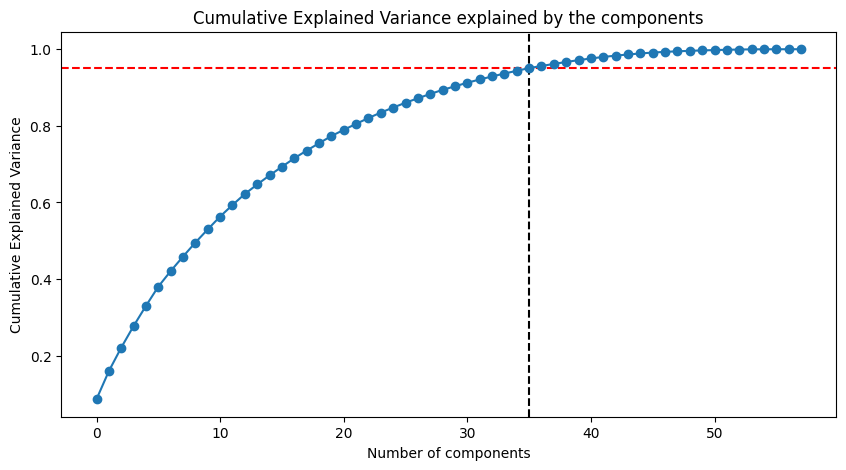

In [131]:
plt.figure(figsize=[10,5])
plt.title('Cumulative Explained Variance explained by the components')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of components')
plt.axvline(x=components_number, color="k", linestyle="--")
plt.axhline(y=threshold, color="r", linestyle="--")
plt.plot(cumulative_var, marker='o')
plt.show()

In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 153
Data columns (total 58 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Age               154 non-null    int64   
 1   Gender            154 non-null    int64   
 2   Locality          154 non-null    int64   
 3   Maritalstatus     154 non-null    int64   
 4   LifeStyle         154 non-null    int64   
 5   Sleep             154 non-null    int64   
 6   Category          154 non-null    int64   
 7   Depression        154 non-null    int64   
 8   Hyperlipi         154 non-null    int64   
 9   Smoking           154 non-null    int64   
 10  FHistory          154 non-null    int64   
 11  Diabetes          154 non-null    int64   
 12  HTN               154 non-null    int64   
 13  Allergies         154 non-null    int64   
 14  BP                154 non-null    float64 
 15  Thrombolysis      154 non-null    int64   
 16  BGR               154 non-

## Modeling

In [121]:
def calculate_metrics(target, prediction, average='macro'):
    accuracy = accuracy_score(target, prediction)
    precision = precision_score(target, prediction, average=average, zero_division = 0)
    recall = recall_score(target, prediction, average=average)
    f1 = f1_score(target, prediction, average=average)
    roc = roc_auc_score(target, prediction)
    mislabeled = (target != prediction).sum()
    total = len(target)
    return accuracy, precision, recall, f1, roc, mislabeled, total

def print_results(metrics, classifier_id='classifier'):
    print(f'Results for {classifier_id}')
    print('----')
    print(f'  Accuracy:  {metrics[0]}')
    print(f'  Precision: {metrics[1]}')
    print(f'  Recall:    {metrics[2]}')
    print(f'  F1 score:  {metrics[3]}')
    print(f'  ROC score: {metrics[4]}')
    print(f'  Mislabeled {metrics[5]} out of {metrics[6]}')
    print('\n')
    
def get_classes(y):
    zeros = len([x for x in y if x == 0])
    ones = len([x for x in y if x == 1])
    print(f'Quantities are {zeros} for 0, {ones} for 1')

In [122]:
y = df.pop('Mortality') #dependent variable
X = df[significant_columns] # independent variables

KeyError: "['Mortality'] not in index"

In [92]:
# splitting into train and test, validation will be split later
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42,
                                                   stratify=y
                                                   )

In [93]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

kfoldcv = KFold(n_splits=5,
                shuffle=True,
                random_state=42
               )


for n, (train, val) in enumerate(kfoldcv.split(X_train, y_train), 1):
    X_train_fold, y_train_fold = X.iloc[train], y.iloc[train]
    X_val_fold, y_val_fold = X.iloc[val], y.iloc[val]
    
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.fit_transform(X_val_fold)
    
    rfc = AdaBoostClassifier()
    rfc.fit(X_train_scaled, y_train_fold)
    y_pred = rfc.predict(X_val_scaled)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_classes(y_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd')
    plt.show()

ValueError: could not convert string to float: 'NO'

In [66]:
# Metrics are not consistent, perhaps let's see, if there are better hyperparameters


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                      test_size=0.25,
                                                      random_state=42,
                                                      stratify=y_train
                                                     )

def objective(trial):

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.fit_transform(X_val)
    

    n_estimators = trial.suggest_int('n_estimators', 100,600)
    learning_rate = trial.suggest_float('learning_rate', 0.001,1)
 

    xbg2 = AdaBoostClassifier(
                               n_estimators=n_estimators,
                               learning_rate=learning_rate
                              )

    xbg2.fit(X_train_scaled, y_train)
    y_pred_val = xbg2.predict(X_val_scaled)
    roc = roc_auc_score(y_val, y_pred_val)
    return roc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

[I 2023-09-24 22:40:12,700] A new study created in memory with name: no-name-0460de0b-4922-4ec2-ae2a-eaabf4439929
[I 2023-09-24 22:40:13,129] Trial 0 finished with value: 0.7933333333333332 and parameters: {'n_estimators': 568, 'learning_rate': 0.9987549665834048}. Best is trial 0 with value: 0.7933333333333332.
[I 2023-09-24 22:40:13,566] Trial 1 finished with value: 0.7933333333333332 and parameters: {'n_estimators': 597, 'learning_rate': 0.7015264138127344}. Best is trial 0 with value: 0.7933333333333332.
[I 2023-09-24 22:40:13,944] Trial 2 finished with value: 0.7933333333333332 and parameters: {'n_estimators': 512, 'learning_rate': 0.4360565118767118}. Best is trial 0 with value: 0.7933333333333332.
[I 2023-09-24 22:40:14,060] Trial 3 finished with value: 0.8133333333333332 and parameters: {'n_estimators': 150, 'learning_rate': 0.19613714050286604}. Best is trial 3 with value: 0.8133333333333332.
[I 2023-09-24 22:40:14,495] Trial 4 finished with value: 0.73 and parameters: {'n_est

In [67]:
best_params = study.best_params
best_params

{'n_estimators': 150, 'learning_rate': 0.19613714050286604}

Results for 1
----
  Accuracy:  0.7368421052631579
  Precision: 0.5729166666666666
  Recall:    0.5583333333333333
  F1 score:  0.5622119815668203
  ROC score: 0.5583333333333335
  Mislabeled 5 out of 19


Quantities are 15 for 0, 4 for 1


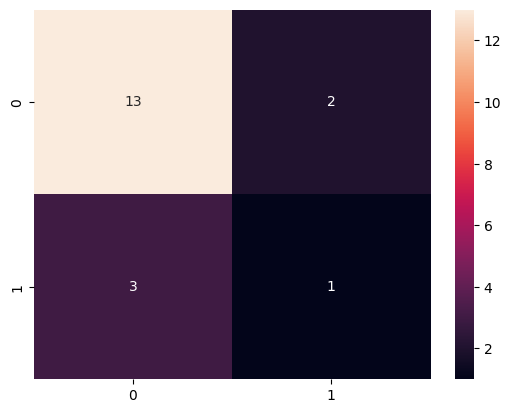

Results for 2
----
  Accuracy:  0.6842105263157895
  Precision: 0.40625
  Recall:    0.40625
  F1 score:  0.40625
  ROC score: 0.40625
  Mislabeled 6 out of 19


Quantities are 16 for 0, 3 for 1


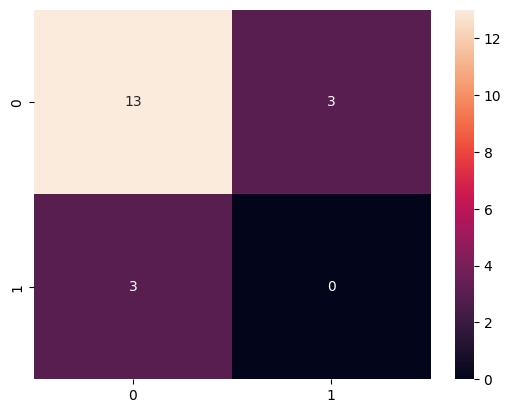

Results for 3
----
  Accuracy:  0.7777777777777778
  Precision: 0.8823529411764706
  Recall:    0.6
  F1 score:  0.6
  ROC score: 0.6
  Mislabeled 4 out of 18


Quantities are 13 for 0, 5 for 1


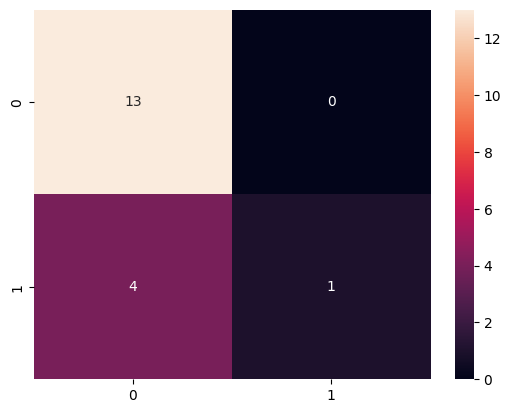

Results for 4
----
  Accuracy:  0.9444444444444444
  Precision: 0.9705882352941176
  Recall:    0.75
  F1 score:  0.8181818181818181
  ROC score: 0.75
  Mislabeled 1 out of 18


Quantities are 16 for 0, 2 for 1


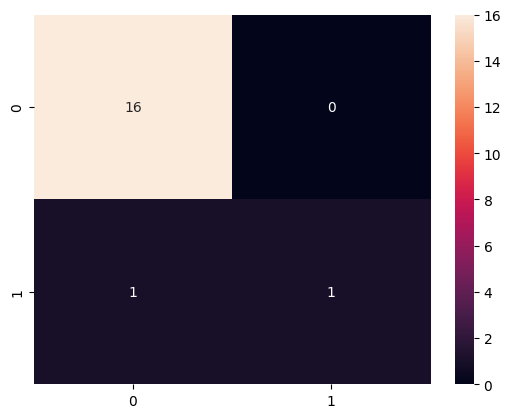

Results for 5
----
  Accuracy:  0.6666666666666666
  Precision: 0.5178571428571428
  Recall:    0.5178571428571428
  F1 score:  0.5178571428571428
  ROC score: 0.5178571428571428
  Mislabeled 6 out of 18


Quantities are 14 for 0, 4 for 1


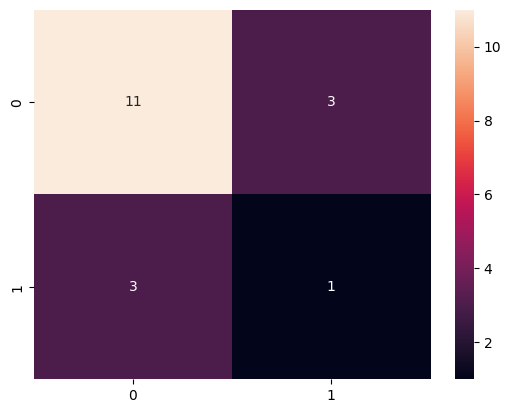

In [68]:
for n, (train, val) in enumerate(kfoldcv.split(X_train, y_train), 1):
    X_train_fold, y_train_fold = X.iloc[train], y.iloc[train]
    X_val_fold, y_val_fold = X.iloc[val], y.iloc[val]
    
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.fit_transform(X_val_fold)
    
    best_params = study.best_params
    ada = AdaBoostClassifier(
                         n_estimators=best_params['n_estimators'],
                         learning_rate=best_params['learning_rate']
                              )    
                              
    ada.fit(X_train_scaled, y_train_fold)
    y_pred = ada.predict(X_val_scaled)
    
    print_results(calculate_metrics(y_val_fold, y_pred), classifier_id=n)
    get_classes(y_val_fold)
    cm = confusion_matrix(y_val_fold, y_pred)
    sns.heatmap(cm, annot = True, fmt = 'd')
    plt.show()

In [69]:
adaboost_model = AdaBoostClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Trenuj modele na danych treningowych
adaboost_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Dokonaj predykcji na danych testowych
adaboost_predictions = adaboost_model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test)

# Uśrednij predykcje z obu modeli
average_predictions = np.mean([adaboost_predictions, xgb_predictions], axis=0)

# Oblicz AUC-ROC dla predykcji uśrednionych
roc_auc_average = roc_auc_score(y_test, average_predictions)

print("AUC-ROC Score for Averaged Predictions:", roc_auc_average)

AUC-ROC Score for Averaged Predictions: 0.8384615384615384


In [70]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np

# Inicjalizuj modele
adaboost_model = AdaBoostClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Kombinuj predykcje z kilku modeli (ensemble)
def combine_predictions(models, X):
    predictions = np.zeros((len(X),))
    for model in models:
        predictions += model.predict(X)
    return predictions / len(models)

# Lista modeli do uwzględnienia w ensemble
ensemble_models = [adaboost_model, xgb_model]

# Inicjalizuj scalera
scaler = StandardScaler()

# Inicjalizuj KFold
kfoldcv = KFold(n_splits=4, random_state=42, shuffle=True)

# Pętla walidacyjna
for n, (train, val) in enumerate(kfoldcv.split(X_train, y_train), 1):
    X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
    X_val_fold, y_val_fold = X_train.iloc[val], y_train.iloc[val]
    
    # Skaluj dane
    X_train_scaled = scaler.fit_transform(X_train_fold)
    X_val_scaled = scaler.transform(X_val_fold)
    
    # Trenuj modele
    models_predictions = []
    for model in ensemble_models:
        model.fit(X_train_scaled, y_train_fold)
        models_predictions.append(model.predict(X_val_scaled))
    
    # Kombinuj predykcje modeli
    combined_predictions = combine_predictions(ensemble_models, X_val_scaled)
    combined_predictions[combined_predictions == 0.5] = 1
    
    # Oblicz AUC-ROC dla uśrednionych predykcji
    roc_auc_combined = roc_auc_score(y_val_fold, combined_predictions)
    combined_f1_score = f1_score(y_val_fold, combined_predictions)
    
    print("AUC-ROC Score for Combined Predictions:", roc_auc_combined)
    print("F1 Score for Combined Predictions:", combined_f1_score)

AUC-ROC Score for Combined Predictions: 0.5723684210526316
F1 Score for Combined Predictions: 0.28571428571428575
AUC-ROC Score for Combined Predictions: 0.4950980392156863
F1 Score for Combined Predictions: 0.2
AUC-ROC Score for Combined Predictions: 0.5723684210526316
F1 Score for Combined Predictions: 0.28571428571428575
AUC-ROC Score for Combined Predictions: 0.726190476190476
F1 Score for Combined Predictions: 0.5


In [155]:
combined_predictions

array([1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.])

In [71]:
feat_importance_ada = adaboost_model.feature_importances_

# Tworzenie DataFrame z ważnością cech
feat_importance_ada_df = pd.DataFrame({'Feature': X.columns, 'Importance': feat_importance_ada})
feat_importance_ada_df = feat_importance_ada_df.sort_values(by='Importance', ascending=False)

print("AdaBoost Feature Importance:")
print(feat_importance_ada_df)

AdaBoost Feature Importance:
     Feature  Importance
5        Age        0.24
9    oldpeak        0.20
1     Gender        0.10
12  FollowUp        0.10
0   AgeGroup        0.08
8        WBC        0.08
10        ca        0.08
2    Smoking        0.06
4    SKReact        0.04
6   FHistory        0.02
3        HTN        0.00
7   Diabetes        0.00
11  Reaction        0.00


In [72]:
feat_importance_xgb = xgb_model.feature_importances_

# Tworzenie DataFrame z ważnością cech
feat_importance_xgb_df = pd.DataFrame({'Feature': X.columns, 'Importance': feat_importance_xgb})
feat_importance_xgb_df = feat_importance_xgb_df.sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(feat_importance_xgb_df)

XGBoost Feature Importance:
     Feature  Importance
1     Gender    0.316835
10        ca    0.129222
5        Age    0.121416
8        WBC    0.087971
0   AgeGroup    0.083610
9    oldpeak    0.071840
12  FollowUp    0.069294
7   Diabetes    0.043132
2    Smoking    0.040909
4    SKReact    0.035772
3        HTN    0.000000
6   FHistory    0.000000
11  Reaction    0.000000
